# Pre processing

In [1]:
import os
import sys
import random
import warnings
import cv2
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label


# TRANSFORM IMAGES

In [2]:
RAW_IMAGES_PATH = '../../data/raw_data/malaria/images/'
BOUNDING_BOX_PATH =  '../../data/raw_data/malaria/'

In [3]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRANSFORMED_PATH = '../../data/raw_data/malaria/transformed_images/'
GENERATED_MASK_PATH = '../../data/raw_data/malaria/masks/'

In [4]:
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

### Mask Categories

In [3]:
MASK_CATEGORIES = ['trophozoite','ring', 'schizont', 'gametocyte']
#MASK_CATEGORIES = ['trophozoite']

## Load TRAIN dataset

In [6]:
train_bounding_box_df = pd.read_json(BOUNDING_BOX_PATH + 'training.json')
train_bounding_box_df['path'] = train_bounding_box_df['image'].map(lambda x: BOUNDING_BOX_PATH + x['pathname'][1:])

print(train_bounding_box_df.shape[0], 'images')
print(train_bounding_box_df.shape[0], 'images available')
train_bounding_box_df.sample(5)

1208 images
1208 images available


,image,objects,path
95,{'checksum': 'be1b6e949aa04ff0ce6b01cc9d56bdc4...,"[{'bounding_box': {'minimum': {'r': 470, 'c': ...",../../data/raw_data/malaria/images/e0e6b676-c3...
90,{'checksum': '5b59db6e92d4c98821d9b95b7e631d7c...,"[{'bounding_box': {'minimum': {'r': 563, 'c': ...",../../data/raw_data/malaria/images/afa470d9-c7...
1018,{'checksum': '0d2f7b75dca04ed7343b91b9289bf3b1...,"[{'bounding_box': {'minimum': {'r': 961, 'c': ...",../../data/raw_data/malaria/images/9106a6bb-13...
1000,{'checksum': '0edee9495f126c2bd806b81ceebbf5cd...,"[{'bounding_box': {'minimum': {'r': 721, 'c': ...",../../data/raw_data/malaria/images/da49db57-0c...
1117,{'checksum': '24ebaeaa0b2edddc565f7adf6e616bbb...,"[{'bounding_box': {'minimum': {'r': 173, 'c': ...",../../data/raw_data/malaria/images/2ae3e6e6-74...


In [7]:
objects = []
for im_index, c_row in train_bounding_box_df.iterrows():
    for c_item in c_row['objects']:
        c_item.update({'im_index':im_index})
        objects.append(dict(image=c_row['path'], **c_item))
        
object_df = pd.DataFrame(objects)


In [8]:
#object_df = pd.DataFrame([dict(image=c_row['path'], **c_item) for im_index, c_row in train_bounding_box_df.iterrows() for c_item in c_row['objects']])
cat_dict = {v:k for k,v in enumerate(object_df['category'].value_counts().index, 1)}
print(object_df['category'].value_counts())
object_df.sample(3)

red blood cell    77420
trophozoite        1473
difficult           441
ring                353
schizont            179
gametocyte          144
leukocyte           103
Name: category, dtype: int64


,bounding_box,category,im_index,image
42991,"{'minimum': {'r': 772, 'c': 857}, 'maximum': {...",red blood cell,670,../../data/raw_data/malaria/images/ff37dd9b-2e...
21165,"{'minimum': {'r': 892, 'c': 391}, 'maximum': {...",red blood cell,324,../../data/raw_data/malaria/images/fb05b297-18...
41605,"{'minimum': {'r': 625, 'c': 164}, 'maximum': {...",red blood cell,647,../../data/raw_data/malaria/images/0fcd1ebe-ee...


In [9]:
cat_dict

{'red blood cell': 1,
 'trophozoite': 2,
 'difficult': 3,
 'ring': 4,
 'schizont': 5,
 'gametocyte': 6,
 'leukocyte': 7}

## Transform Training Data

### Parameters

In [10]:
total_images = train_bounding_box_df.shape[0]

X_train = []
masks_train = []

In [11]:
object_df.count()

bounding_box    80113
category        80113
im_index        80113
image           80113
dtype: int64

In [ ]:
print('Getting and resizing train images  ... ')
sys.stdout.flush()

for n, row in tqdm(train_bounding_box_df.iterrows(), total=total_images):
    img_path = row['path']
    img = imread( img_path )[:,:,:IMG_CHANNELS]
    
    ## Generate mask with original size
    masks_train.append( np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8) )
    
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train.append(img/255)

In [13]:
print('Generating masks ... ')
sys.stdout.flush()
object_df_count = object_df.shape[0]

for n, row in tqdm(object_df.iterrows(), total=object_df_count):
    #print(row)
    min_val = row['bounding_box']['minimum']
    max_val = row['bounding_box']['maximum']
    im_index = row['im_index']
    
    if(row['category'] in MASK_CATEGORIES) :
        mask =  masks_train[im_index]
        mask[slice(min_val['r'], max_val['r']), slice(min_val['c'], max_val['c'])] = 1
        masks_train[im_index] = mask
   
    

Generating masks ... 


100%|██████████| 80113/80113 [00:06<00:00, 11625.98it/s]


In [14]:
print("Reshape masks for training data set")
masks_train_transformed = []

for mask in tqdm(masks_train, total=total_images):
    new_mask = cv2.resize(mask, dsize=(IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_NEAREST)
    masks_train_transformed.append(np.expand_dims(new_mask, axis=2))

  0%|          | 0/1208 [00:00<?, ?it/s]

Reshape masks for training data set


100%|██████████| 1208/1208 [00:00<00:00, 2278.64it/s]


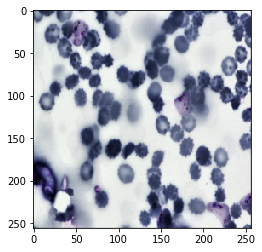

In [15]:
plt.imshow(X_train[0])

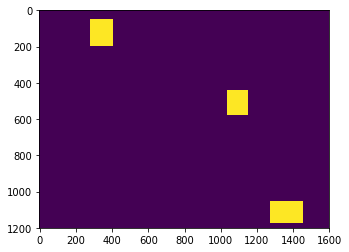

In [16]:
plt.imshow(masks_train[0])

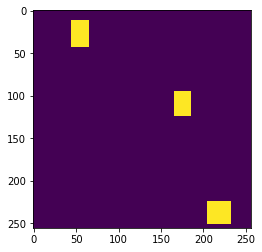

In [17]:
plt.imshow(np.squeeze(masks_train_transformed[0]))

In [18]:
from skimage.color import label2rgb

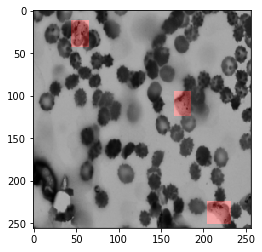

In [19]:
plt.imshow(label2rgb(label=np.squeeze(masks_train_transformed[0]), image=X_train[0], bg_label=0))

## TEST dataset

In [7]:
X_test = []
masks_test = []

In [8]:
test_bounding_box_df = pd.read_json(BOUNDING_BOX_PATH + 'test.json')
test_bounding_box_df['path'] = test_bounding_box_df['image'].map(lambda x: BOUNDING_BOX_PATH + x['pathname'][1:])

print(test_bounding_box_df.shape[0], 'images')
print(test_bounding_box_df.shape[0], 'images available')


120 images
120 images available


In [9]:
objects_test = []
for im_index, c_row in test_bounding_box_df.iterrows():
    for c_item in c_row['objects']:
        c_item.update({'im_index':im_index})
        objects_test.append(dict(image=c_row['path'], **c_item))
        
object_test_df = pd.DataFrame(objects_test)

In [10]:
total_test_images = test_bounding_box_df.shape[0]
total_test_images

120

In [11]:
print('Getting and resizing test images  ... ')
sys.stdout.flush()

for n, row in tqdm(test_bounding_box_df.iterrows(), total=total_test_images):
    img_path = row['path']
    img = imread( img_path )[:,:,:IMG_CHANNELS]
    
    ## Create image mask with original size
    masks_test.append( np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8) )
    
    ## Reshape image
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test.append(img/255)
    
   

Getting and resizing test images  ... 


100%|██████████| 120/120 [00:25<00:00,  4.71it/s]


In [12]:
print('Generating test masks original size ... ')
sys.stdout.flush()
object_test_df_count = object_test_df.shape[0]
for n, row in tqdm(object_test_df.iterrows(), total=object_test_df_count):

    min_val = row['bounding_box']['minimum']
    max_val = row['bounding_box']['maximum']
    im_index = row['im_index']
    
    if(row['category'] in MASK_CATEGORIES) :
        mask =  masks_test[im_index]
        mask[slice(min_val['r'], max_val['r']), slice(min_val['c'], max_val['c'])] = 1
        masks_test[im_index] = mask

Generating test masks original size ... 


100%|██████████| 5922/5922 [00:00<00:00, 11208.04it/s]


#### Reshape Masks

In [13]:
print("Reshape masks for test data set")
masks_test_transformed = []

for mask in tqdm(masks_test, total=total_test_images):
    new_mask = cv2.resize(mask, dsize=(IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_NEAREST)
    masks_test_transformed.append(np.expand_dims(new_mask, axis=2))
    

print(masks_test_transformed[0].shape)
print("Done !")

  0%|          | 0/120 [00:00<?, ?it/s]

Reshape masks for test data set


100%|██████████| 120/120 [00:00<00:00, 390.83it/s]

(256, 256, 1)
Done !


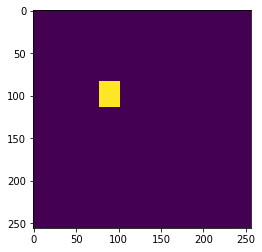

In [14]:
plt.imshow(np.squeeze(masks_test_transformed[0]))

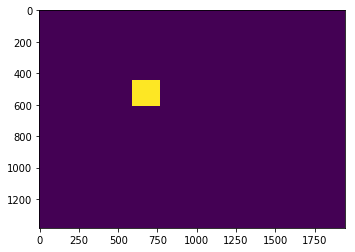

In [15]:
plt.imshow(masks_test[0])

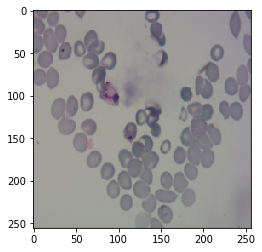

In [16]:
plt.imshow(X_test[0])
#X_test[0]

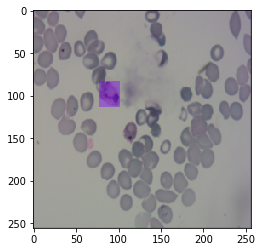

In [17]:
plt.imshow(X_test[0], )    # Also set the cmap to gray
plt.imshow(np.where(np.squeeze(masks_test_transformed[0])>0, 1, np.nan), cmap='rainbow',alpha=0.4)

## SAVE DATA

### TRAINING DATASET

In [19]:
str_masks_name = '_'.join(MASK_CATEGORIES)

In [37]:
train_dataset_name = 'malaria_train_transformed_' + str(IMG_WIDTH) + '_' + str(IMG_HEIGHT)
print(train_dataset_name)
print(train_dataset_name + '_names')
print(train_dataset_name + '_masks_' + str_masks_name)

malaria_train_transformed_256_256
malaria_train_transformed_256_256_names
malaria_train_transformed_256_256_masks_trophozoite


In [20]:
np.save(TRANSFORMED_PATH + train_dataset_name , X_train)

In [21]:
np.save(TRANSFORMED_PATH + train_dataset_name + '_names', train_bounding_box_df['path'])

In [ ]:
masks_train_transformed.shape

In [38]:
np.save(TRANSFORMED_PATH + train_dataset_name + '_masks_'+ str_masks_name, masks_train_transformed)

### TEST DATASET

In [20]:
test_dataset_name = 'malaria_test_transformed_' + str(IMG_WIDTH) + '_' + str(IMG_HEIGHT)
print(test_dataset_name)
print(test_dataset_name + '_names')
print(test_dataset_name + '_masks_' + str_masks_name)

malaria_test_transformed_256_256
malaria_test_transformed_256_256_names
malaria_test_transformed_256_256_masks_trophozoite


In [35]:
np.save(TRANSFORMED_PATH + test_dataset_name, X_test)

In [36]:
np.save(TRANSFORMED_PATH + test_dataset_name + '_names', test_bounding_box_df['path'])

In [21]:
np.save(TRANSFORMED_PATH + test_dataset_name + '_masks_'+str_masks_name, masks_test_transformed)

In [47]:
TRANSFORMED_PATH

'../../data/raw_data/malaria/transformed_images/'